In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from skimage.segmentation import clear_border
from skimage import measure 
from skimage.measure import label, regionprops
from scipy import ndimage as ndi 
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom 
import plotly.graph_objects as go 
import plotly.io as pio
import plotly.offline as pyo
import os 
import cv2
from PIL import Image 

In [2]:
%config InlineBackend.figure_format = 'svg'
pio.renderers.default = 'svg'

In [3]:
adenocarcinoma_path_training = 'Data/Kaggle_Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/'
adenocarcinoma_path_test = 'Data/Kaggle_Data/test/adenocarcinoma/'

In [4]:
class NPmatrix_of_images():
    def __init__(self, path, format='.png', bitdepth=8, color='RGB') -> None:
        super().__init__()
        self.color = color
        self.bit = bitdepth
        self.maxvalue = 2**(self.bit) - 1
        self.path = path
        self.max_width, self.max_height = 0, 0
        self.image_filenames = [f for f in os.listdir(path) if f.endswith(format)]
        self.N = len(self.image_filenames)
        if self.color == 'CMYK': 
            self.extradim = 4 
        elif self.color == 'RGB':
            self.extradim = 3
        elif self.color == 'L':
            self.extradim = 0
        else: 
            raise NotImplementedError(color)
        
    def max_brightness(self): 
        return self.maxvalue
    
    def find_max_dims(self):
        for filename in self.image_filenames:
            img = Image.open(os.path.join(self.path, filename))
            w, h = img.size 
            if w > self.max_width: 
                self.max_width = w 
            if h > self.max_height:
                self.max_height = h 
        if self.extradim == 0:
            self.images = np.zeros((self.N, self.max_height, self.max_width))
        else: 
            self.images = np.zeros((self.N, self.max_height, self.max_width, self.extradim))

    def load_images_from_path(self):
        self.find_max_dims()
        for index, filename in enumerate(self.image_filenames):
            if self.color == 'RGB' or self.color == 'CMYK':
                img = Image.open(os.path.join(self.path, filename)).convert(self.color)
                img_arr = np.asarray(img)[:, :, :self.extradim]
            else:
                img = Image.open(os.path.join(self.path, filename)).convert(self.color)
                img_arr = np.asarray(img)
            self.images[index, :img_arr.shape[0], :img_arr.shape[1]] = img_arr
        return self.images

I had no access to the original dataset that was already prepackaged into a numpy array of 263 images of resolution 512x512, so I had to create my own class to deal with a PNG dataset I downloaded from Kaggle, which had all sorts of issues, included unmatching resolutions that I had to pad with pixel of value 0 to the max res found, an unnecessary alpha channel that I suppressed, etc. Hopefully this will give me something to work with though. 

In [24]:
img = NPmatrix_of_images(adenocarcinoma_path_training, color='L').load_images_from_path()
img = img[0:-22, :, :]
img.shape

(173, 874, 1200)

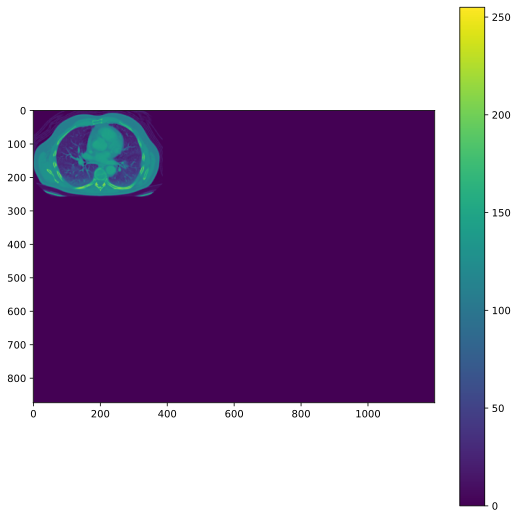

In [25]:
plt.figure(figsize=(9, 9))
plt.imshow(img[20])
plt.colorbar()
plt.show()

The dataset I downloaded from Kaggle sucks, I doubt the images could be useful for stacking since their resolutions don't match and there's no alignment between them. Anyway, even if this is ugly, that should work for image segmentation, I guess.

# Image values

The pixel values of each image is expressed in **Hounsfield Units** 

$$ HU(x, y) \equiv 1000 \cdot \displaystyle \frac{\mu(x, y) - \mu_{water}}{\mu_{water} - \mu_{air}} $$

where $\mu(x, y)$ is the linear attenuation coefficient of the material at position $(x, y)$, $\mu_{water}$ is the linear attenuation coefficient of water and $\mu_{air}$ is the linear attenuation coefficient of air.

This linear attenuation coefficient is defined on how the intensity of a photon beam decays as it passes a distance $x$ through a material 

$$ I = I_0 \cdot e^{-\mu \cdot x} $$

where $\mu$ depends on the energy of the incident photon beam, which for CT scans is $\approx 100 \ keV$.


| Substance | HU Value |
| --- | ---: |
| Air | -1000 |
| Fat | -120 to -70 |
| Water | 0 |
| Blood | 30 to 45 |
| Muscle | 10 to 40 |
| Bone | 1000 to 3000 |

My values are between 0 and $2^{8} - 1 = 255$, so I'll have to normalize them to be between -1000 and 1000. 

In [26]:
def HU_normalize(array, nbit):
    return (2 * (array / (2**nbit - 1)) - 1) * 1000

In [27]:
img_normalized = HU_normalize(img, 8)

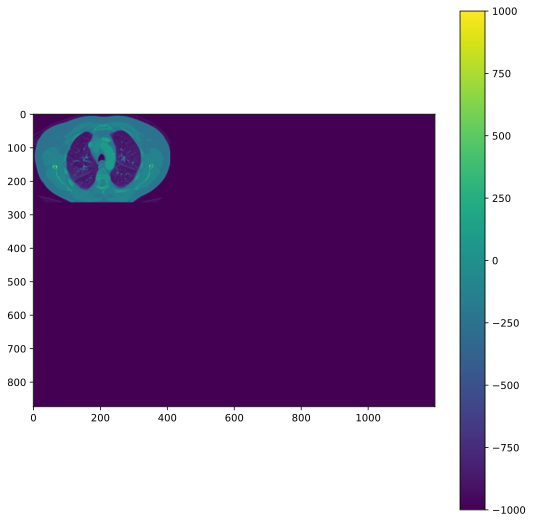

In [30]:
plt.figure(figsize=(9, 9))
plt.imshow(img_normalized[0])
plt.colorbar()
plt.show()

Everything should be fine now, so we can proceed.

## Modify the dataset

We need to create a mask for the lungs, so it's a good idea to point out that the lungs are the only part of the body that is filled with air, so we can use that to our advantage. We know that air has a significantly lower HU value than most substances, so we can arbitrarily set a threshold to have a first cleanup of the dataset. 

Let's set the threshold to -320 HU as the lower bound:

In [202]:
mask = img_normalized < -300

Let's plot the mask

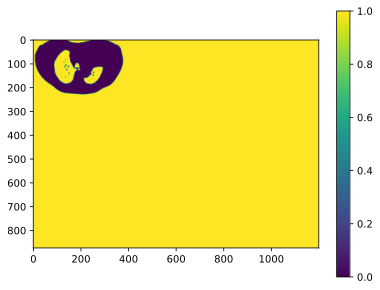

In [203]:
plt.imshow(mask[10])
plt.colorbar()
plt.show()

We can do some further cleanup with the `clear_border` function from `skimage.morphology` to remove any connected components that are touching the border of the image.

We can do that for each mask, so we need to loop through the first dimension of the array, which represents the number of images. Note that instead of using for loops, the `apply_along_axis` function from `numpy` is used to conveniently apply the function to each 2D slice of the 3D array.

Let's update the mask:

In [51]:
mask.shape

(173, 874, 1200)

In [204]:
mask = np.apply_along_axis(clear_border, axis=0, arr=mask)

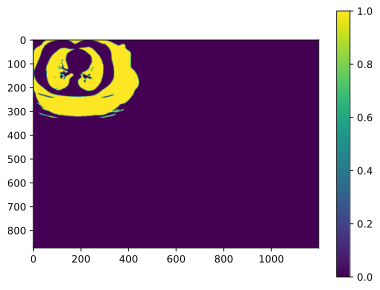

In [205]:
plt.imshow(mask[30])
plt.colorbar()
plt.show()

Another potential cleanup to do is removing the portions of the table that appear in some of the images.

One approach could be removing the connected components that are smaller than a certain size, but there's no guarantee that the table will be the smallest connected component (in terms of area), for each image.

What we could do instead, is giving a different integer value to each separate volume, using the `label` function from `skimage.measure`, and then removing the connected components that are not part of the lungs.

Let's reuse the `apply_along_axis` function to apply the `label` function to each slice of the 3D array.

In [206]:
mask_labeled = np.apply_along_axis(label, axis=0, arr=mask)

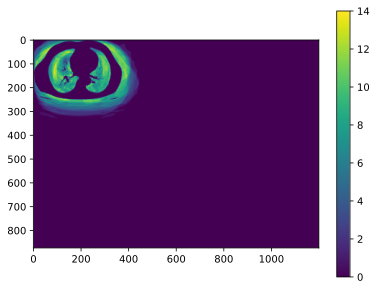

In [208]:
plt.imshow(mask_labeled[40])
plt.colorbar()
plt.show()

Now we can keep the three largest areas. We can calculate the areas of each connected component using the `regionprops` function from `skimage.measure`, and then sort them by area in descending order.

In [211]:
slice = mask_labeled[40]
rps = regionprops(slice) # returns the properties of each region
areas = [r.area for r in rps]
indexes = np.argsort(areas)[::-1] # largest to smallest
areas

[6692,
 7327,
 4048,
 4446,
 5711,
 5790,
 7011,
 8569,
 9388,
 8349,
 6555,
 2097,
 548,
 71]

We can consider the 3 largest areas and add them to a new slice of zeros

In [212]:
new_slice = np.zeros_like(slice)
new_slice

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [213]:
rps[1]

In [214]:
rps[1].coords

array([[  0,  71],
       [  0,  72],
       [  0,  73],
       ...,
       [317, 205],
       [317, 206],
       [317, 207]])

In [215]:
rps[1].coords.T

array([[  0,   0,   0, ..., 317, 317, 317],
       [ 71,  72,  73, ..., 205, 206, 207]])

In [216]:
tuple(rps[1].coords.T)

(array([  0,   0,   0, ..., 317, 317, 317]),
 array([ 71,  72,  73, ..., 205, 206, 207]))

In [217]:
new_slice[tuple(rps[1].coords.T)]

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [218]:
new_slice[tuple(rps[1].coords.T)] = 10
new_slice[tuple(rps[1].coords.T)]

array([10, 10, 10, ..., 10, 10, 10], dtype=int32)

In [219]:
for i in indexes[:3]: 
    new_slice[tuple(rps[i].coords.T)] = i + 1

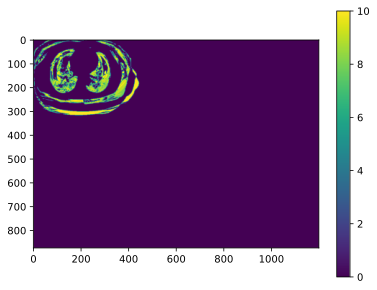

In [220]:
plt.imshow(new_slice)
plt.colorbar()
plt.show()

Now let's do this for all the images

In [224]:
def keep_top_N(slice, N=3):
    new_slice = np.zeros_like(slice)
    rps = regionprops(slice)
    areas = [r.area for r in rps]
    indexes = np.argsort(areas)[::-1]
    for j in indexes[:N]:
        new_slice[tuple(rps[j].coords.T)] = j + 1
    return new_slice

In [225]:
vectorized_keep_top_N = np.vectorize(keep_top_N, signature='(n,m)->(n,m)')

In [226]:
mask_labeled = vectorized_keep_top_N(mask_labeled)

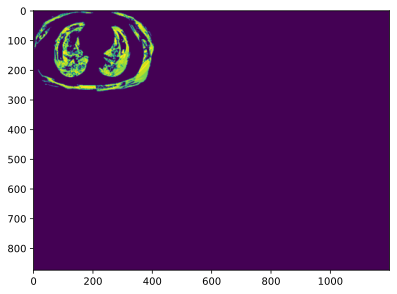

In [237]:
plt.imshow(mask_labeled[40])
plt.show()

The mask is far from being perfect as it's fragmented with small holes. Let's fill them like this:

In [240]:
fill_mask = mask_labeled > 0
fill_mask = np.apply_along_axis(ndi.binary_fill_holes, axis=0, arr=fill_mask)

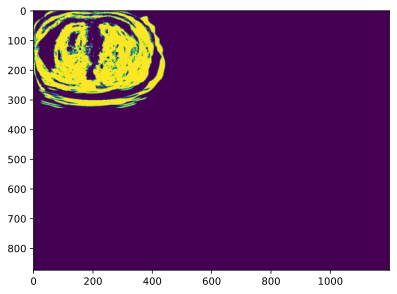

In [241]:
plt.imshow(fill_mask[40])
plt.show()

I'm making a mess, I'll redo everything after finding a decent dataset.